# Imports

In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 999
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 400

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score,\
     ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

# Pulling in the Data & Quick EDA

In [493]:
subreddits = pd.read_csv('./data_clean/subreddits_cleaned.csv')

In [494]:
subreddits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6170 entries, 0 to 6169
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   author            6170 non-null   object
 1   topic             6170 non-null   object
 2   title             6170 non-null   object
 3   text              6170 non-null   object
 4   num_comments      6170 non-null   int64 
 5   is_dogs           6170 non-null   int64 
 6   title_length      6170 non-null   int64 
 7   title_word_count  6170 non-null   int64 
 8   text_length       6170 non-null   int64 
 9   text_word_count   6170 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 482.2+ KB


# Vectorizing the Text Feature for Dogs & Parenting Subreddits

In [495]:
countvect = CountVectorizer()

In [496]:
# Using CountVectorizer to look at words in Dogs subreddit (title feature)
dogs_text_vect = pd.DataFrame(
    countvect.fit_transform(subreddits[subreddits['is_dogs']==1]['text']).todense(),
    columns=countvect.get_feature_names_out()
)

dogs_text_count = dogs_text_vect.sum(axis=0).sort_values(ascending=False)

dogs_text_top = pd.DataFrame(data={
    'word': dogs_text_vect.columns, 
    'count': dogs_text_count.values
}).sort_values(by='count', ascending=False)

dogs_text_top.iloc[0:5]

# CITATION: Received help from Katie Sylvia. I was trying to create my vectorized dataframe
# using my best model from my gridsearch below, but couldn't figure out how to extract the
# sparse matrix. Katie shared a portion of this code with me to get me set in the right
# direction here.

,word,count
0,00,18307
1,000,18286
2,00108,16894
3,003,8400
4,00_at9e_f13rtsya46qzjlh0ch9gmrbopksx1o5ljwr7kfoqq,7750


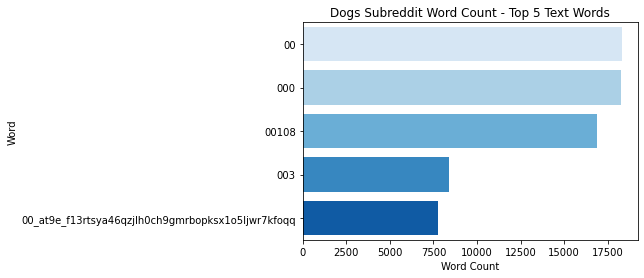

In [497]:
sns.barplot(data=dogs_text_top.head(5), x='count', y='word', palette='Blues', saturation=1)
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Dogs Subreddit Word Count - Top 5 Text Words');

The above barplot shows use the most common "words" in the Dogs subreddit.

In [498]:
# Using CountVectorizer to look at words in Parenting subreddit (text feature)
parenting_text_vect = pd.DataFrame(
    countvect.fit_transform(subreddits[subreddits['is_dogs']==0]['text']).todense(),
    columns=countvect.get_feature_names_out()
)

parenting_text_count = parenting_text_vect.sum(axis=0).sort_values(ascending=False)

parenting_text_top = pd.DataFrame(
    data={
        'word': parenting_text_vect.columns, 
        'count': parenting_text_count.values
    }).sort_values(by='count', ascending=False)
    
parenting_text_top.iloc[0:10]

,word,count
0,00,18092
1,000,17998
2,00am,14168
3,00pm,9032
4,01,7466
5,013527,7316
6,02h00,6957
7,02pm,6754
8,0300,6432
9,04,6068


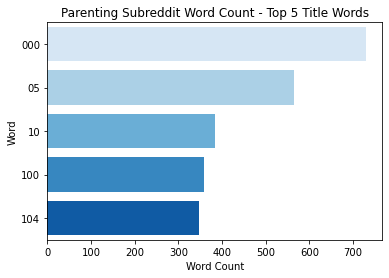

In [499]:
sns.barplot(data=parenting_title_top.head(5), x='count', y='word', palette='Blues', saturation=1)
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Parenting Subreddit Word Count - Top 5 Title Words');

The above barplot shows use the most common "words" in the Parenting subreddit.

# Train Test Split

In [500]:
X = subreddits['text']
y = subreddits['is_dogs']

In [501]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=333)

# Baseline Model  
### DummyClassifier

In [502]:
nullmodel = DummyClassifier()
nullmodel.fit(X_train, y_train)

DummyClassifier()

In [503]:
print('Balanced accuracy score: ', balanced_accuracy_score(y_test, nullmodel.predict(X_test)))
print('Accuracy score: ', accuracy_score(y_test, nullmodel.predict(X_test)))

Balanced accuracy score:  0.5
Accuracy score:  0.5405055087491899


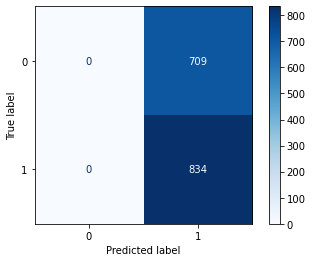

In [504]:
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    nullmodel.predict(X_test), 
    cmap='Blues'
    );

The above confusion matrix shows us how the null model will simply assume that since Dogs are the slight majority of the subreddits in our dataset, the model will predict that each new post belongs to the Dogs subbreddit.

# Model 1
### CountVectorizer transformer & Naive Bayes classifier

In [505]:
cvect = CountVectorizer()
nbayes = MultinomialNB()

pipe1 = make_pipeline(cvect, nbayes)
pipe1.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])>

In [506]:
params1 = {
    'countvectorizer__stop_words': [None, 'english'],
    'countvectorizer__ngram_range':[(1,1), (1,2)], 
    'countvectorizer__max_df':[0.5, 0.7],
    'countvectorizer__min_df':[0, .1],
    'multinomialnb__alpha':[.1, 1, 1.9]
}

In [507]:
gs1 = GridSearchCV(pipe1, params1, n_jobs=-1)
gs1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.5, 0.7],
                         'countvectorizer__min_df': [0, 0.1],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'countvectorizer__stop_words': [None, 'english'],
                         'multinomialnb__alpha': [0.1, 1, 1.9]})

In [508]:
gs1.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_countvectorizer__max_df', 'param_countvectorizer__min_df', 'param_countvectorizer__ngram_range', 'param_countvectorizer__stop_words', 'param_multinomialnb__alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [509]:
results = pd.DataFrame(gs1.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_df,param_countvectorizer__min_df,param_countvectorizer__ngram_range,param_countvectorizer__stop_words,param_multinomialnb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
34,2.525606,0.038478,0.370347,0.007833,0.7,0,"(1, 2)",english,1,"{'countvectorizer__max_df': 0.7, 'countvectorizer__min_df': 0, 'countvectorizer__ngram_range': (1, 2), 'countvectorizer__stop_words': 'english', 'multinomialnb__alpha': 1}",0.976242,0.970842,0.970811,0.964324,0.976216,0.971687,0.004403,1
10,1.995931,0.027647,0.291795,0.008138,0.5,0,"(1, 2)",english,1,"{'countvectorizer__max_df': 0.5, 'countvectorizer__min_df': 0, 'countvectorizer__ngram_range': (1, 2), 'countvectorizer__stop_words': 'english', 'multinomialnb__alpha': 1}",0.976242,0.969762,0.970811,0.964324,0.976216,0.971471,0.004466,2
31,3.629421,0.093624,0.645136,0.026967,0.7,0,"(1, 2)",None,1,"{'countvectorizer__max_df': 0.7, 'countvectorizer__min_df': 0, 'countvectorizer__ngram_range': (1, 2), 'countvectorizer__stop_words': None, 'multinomialnb__alpha': 1}",0.974082,0.973002,0.970811,0.961081,0.978378,0.971471,0.005749,3
7,2.699994,0.055962,0.447842,0.013017,0.5,0,"(1, 2)",None,1,"{'countvectorizer__max_df': 0.5, 'countvectorizer__min_df': 0, 'countvectorizer__ngram_range': (1, 2), 'countvectorizer__stop_words': None, 'multinomialnb__alpha': 1}",0.974082,0.971922,0.969730,0.961081,0.979459,0.971255,0.006026,4
28,0.979159,0.017318,0.228717,0.035250,0.7,0,"(1, 1)",english,1,"{'countvectorizer__max_df': 0.7, 'countvectorizer__min_df': 0, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'multinomialnb__alpha': 1}",0.975162,0.964363,0.972973,0.961081,0.980541,0.970824,0.007135,5


In [510]:
gs1.best_params_

{'countvectorizer__max_df': 0.7,
 'countvectorizer__min_df': 0,
 'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__stop_words': 'english',
 'multinomialnb__alpha': 1}

In [511]:
cols1 = gs1.best_estimator_.named_steps['countvectorizer'].get_feature_names_out()
cols1

array(['00', '00 02', '00 05', ..., '𝗽𝘂𝗽 𝗸𝗶𝘁𝘁𝘆', '𝘆𝗼𝘂', '𝘆𝗼𝘂 𝗴𝗲𝘁'],
      dtype=object)

In [512]:
gs1.best_estimator_.named_steps['multinomialnb'].feature_count_[0]

array([14.,  0.,  0., ...,  0.,  0.,  0.])

In [513]:
parenting_be = pd.DataFrame(
    data=[gs1.best_estimator_.named_steps['multinomialnb'].feature_count_[0], cv_model1.get_feature_names_out()]
).T
parenting_best_est = parenting_be.rename(columns={0: "estimator", 1: "text"}).sort_values(by='estimator', ascending=False).head(20)
parenting_best_est.head()

,estimator,text
119070,2428.0,just
130266,1773.0,like
228710,1612.0,time
67241,1428.0,don
121816,1273.0,kids


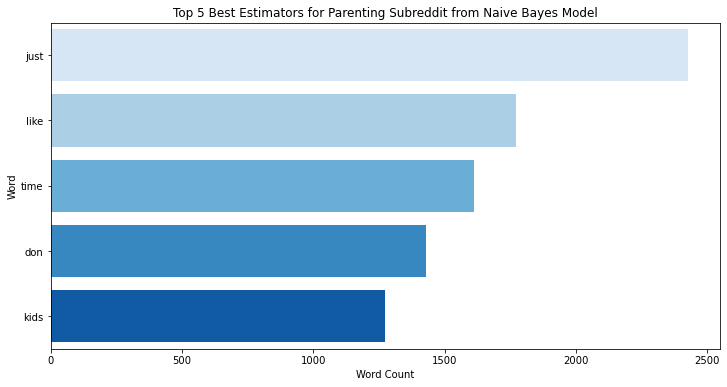

In [514]:
plt.figure(figsize = (12,6))
sns.barplot(data=parenting_best_est.head(5), x='estimator', y='text', palette='Blues', saturation=1)
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Top 5 Best Estimators for Parenting Subreddit from Naive Bayes Model');

The above model shows us the best estimators from the Parenting Subreddit. These gave the highest scores on my test set using the Naive Bayes Model.

In [515]:
dogs_be = pd.DataFrame(
    data=[gs1.best_estimator_.named_steps['multinomialnb'].feature_count_[1], cv_model1.get_feature_names_out()]
).T
dogs_best_est = dogs_be.rename(columns={0: "estimator", 1: "text"}).sort_values(by='estimator', ascending=False).head(20)

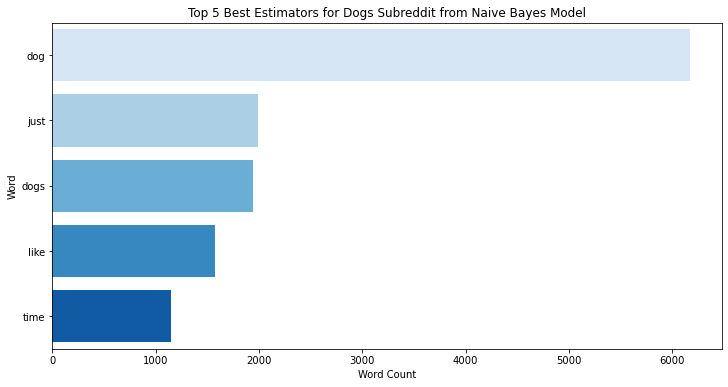

In [516]:
plt.figure(figsize = (12,6))
sns.barplot(data=dogs_best_est.head(5), x='estimator', y='text', palette='Blues', saturation=1)
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Top 5 Best Estimators for Dogs Subreddit from Naive Bayes Model');

The above model shows us the best estimators from the Dogs Subreddit. These gave the highest scores on my test set using the Naive Bayes Model.

### I need to take the best model from above and make it outside of the gridsearch and pipe for it to be useful...

In [517]:
cv_model1 = CountVectorizer(max_df=.7, min_df=0, ngram_range=(1, 2), stop_words='english')

In [518]:
X_train_cv1 = cv_model1.fit_transform(X_train)
X_test_cv1 = cv_model1.transform(X_test)

In [519]:
model1_features = pd.DataFrame(X_train_cv1.toarray(), columns=cv_model1.get_feature_names_out())
model1_features.head()

,00,00 02,00 05,00 11,00 2017,00 60,00 appt,00 bottle,00 climbed,00 definitely,00 depending,00 different,00 going,00 just,00 later,00 pm,00 pyrantel,00 refused,00 removed,00 room,00 showered,00 stop,00 tell,00 today,00 vet,00 view,00 wake,00 wakes,00 walk,000,000 000,000 50,000 500,000 bonus,000 cash,000 didn,000 different,000 government,000 huge,000 humans,000 kid,000 mom,000 norwegian,000 previous,000 sqft,000 square,000 submit,000 sure,000 surgery,000 taxes,000 times,000 truck,000 week,003,003 481,00_at9e_f13rtsya46qzjlh0ch9gmrbopksx1o5ljwr7kfoqq,00_at9e_f13rtsya46qzjlh0ch9gmrbopksx1o5ljwr7kfoqq amp,00am,00am 00pm,00am awake,00am gets,00am lucky,00pm,00pm awake,00pm beginning,00pm need,01,01 04,01 06,01 28,01 lbs,010,010 500,013527,013527 know,02,02 2020,02 21,03,03 00,03 cone,0300,0300 ready,04,04 education,049dw,049dw amp,05,05 00,06,06 30,06 health,0600,0600 past,07,07 24,07 40,07 identifying,07 timothee,09,09 22,09 24,09 ccdr,0cdq0kl9dmjbyurcvlk_wa9fw,0ewdfg5,0ewdfg5 https,0fil2x8,0qchoijyvfq,0qchoijyvfq shows,0rtxeut,0rtxeut week,10,10 00,10 00pm,10 10,10 11,10 11pm,10 12,10 12years,10 15,10 20,10 20min,10 22,10 30,10 30am,10 35,10 3x,10 44am,10 45p,10 4th,10 6am,10 accessories,10 acres,10 additional,10 adults,10 advice,10 application,10 away,10 barking,10 big,10 block,10 bottles,10 boy,10 children,10 colds,10 comfortable,10 couple,10 curious,10 dachshund,10 day,10 days,10 deaf,10 degrees,10 did,10 doesn,10 dog,10 dont,10 double,10 ended,10 energetic,10 ex,10 exact,10 far,10 february,10 finally,10 friend,10 ft,10 gfs,10 gone,10 gordon,10 guess,10 hadn,10 half,10 hard,10 heard,10 hour,10 hours,10 https,10 husband,10 interchange,10 just,10 kg,10 lab,10 lb,10 lbs,10 leave,10 letting,10 makes,10 making,10 matter,10 miles,10 min,10 mind,10 miniature,10 mins,10 minute,10 minutes,10 mon,10 month,10 months,10 nap,10 nearly,10 needs,10 night,10 non,10 norway,10 old,10 overnight,10 party,10 people,10 play,10 pm,10 possible,10 pound,10 pounds,10 pp,10 prepared,10 pretty,10 qd,10 quickly,10 ran,10 really,10 recently,10 seconds,10 semi,10 share,10 shedding,10 sick,10 size,10 sleep,10 small,10 started,10 stay,10 steps,10 study,10 sure,10 takes,10 teeth,10 things,10 think,10 thought,10 thousand,10 times,10 toothpaste,10 total,10 totally,10 trying,10 turn,10 turns,10 uk,10 understand,10 ve,10 waitlists,10 wakes,10 weather,10 week,10 weeks,10 year,10 years,10 yes,10 yo,10 younger,10 yr,10 yrs,100,100 00,100 150,100 1hr,100 363,100 80,100 able,100 accurate,100 acres,100 albeit,100 allergies,100 annual,100 attention,100 australian,100 believer,100 better,100 blame,100 board,100 border,100 bottle,100 capsules,100 church,100 commission,100 completely,100 confident,100 convinced,100 coughing,100 deductible,100 dogs,100 don,100 drained,100 effective,100 fault,100 feel,100 fine,100 firm,100 foster,100 fully,100 funeral,100 hours,100 just,100 know,100 lb,100 love,100 meltdown,100 miles,100 month,100 months,100 normal,100 okay,100 pack,100 parent,100 patients,100 percent,100 plastic,100 positive,100 possible,100 potty,100 pounds,100 present,100 puppy,100 question,100 really,100 recommend,100 reflux,100 reliable,100 right,100 safe,100 satisfied,100 say,100 school,100 series,100 shihtzu,100 sq,100 staying,100 summer,100 support,100 sure,100 time,100 trust,100 using,100 vets,100 want,100 wants,100 won,100 woods,100 words,100 years,1000,1000 2700,1000 blood,1000 emergency,1000 euro,1000 groceries,1000 hard,1000 miles,1000 missing,1000 pressure,1000 sq,1000 times,1000 vet,1000 walks,1000 words,1000 years,100000x,100000x better,100g,100g dry,100g wet,100k,100k year,100lb,100lb boxer,100lb dog,100lb presa,100lb shiloh,100lbs,100lbs kia,100lbs near,100mg,100mg cap,100miles,100miles clinic,100th,100th time,102,102 jan,102f,102f peak,103,103 fever,103 night,1030,1030 nap,104,104 blood,104 spoke,104 yesterday,105,105 february,105lbs,105lbs year,106,106 amp,108,108 76,108 83,10am,10am 10,10am 12pm,10am 1pm,10am administered,10am breakfast,10am makes,10am r

In [520]:
model1_features_sum = model1_features.sum(axis='rows')

model1_top_words = pd.DataFrame(data={
    'word': model1_features.columns, 
    'count': model1_features_sum.values
}).sort_values(by='count', ascending=False).head(15)
model1_top_words

,word,count
63845,dog,6229
119070,just,4414
130266,like,3352
228710,time,2765
67241,don,2565
123582,know,2241
157898,old,2222
247187,want,2139
243070,ve,2009
65751,dogs,1967


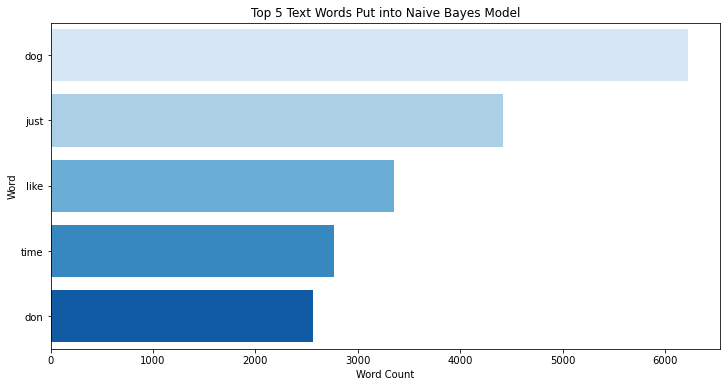

In [521]:
plt.figure(figsize = (12,6))
sns.barplot(data=model1_top_words.head(5), x='count', y='word', palette='Blues', saturation=1)
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Top 5 Text Words Put into Naive Bayes Model');

The above barpplot shows the most common words in the text feature of our data set after the text feature was transformed by the parameters outlined by our model's countvectorizer. The parameters include:
* max_df=.7 -- Any word that's in more than 70% of the observations iscut out
* ngram_range=(1, 2) -- the text is unigrams and bigrams (above we only see unigrams)
* stop_words='english' -- this filters out common english words

In [522]:
nb_model1 = MultinomialNB()

In [523]:
nb_model1.fit(X_train_cv1, y_train)

MultinomialNB()

In [524]:
preds_model1 = nb_model1.predict(X_test_cv1)

In [525]:
accuracy_score(y_test, preds_model1)

0.9766688269604666

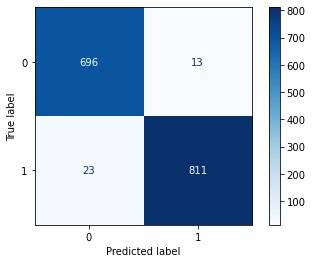

In [526]:
ConfusionMatrixDisplay.from_estimator(nb_model1, X_test_cv1, y_test, cmap='Blues');

The above confusion matrix display shows us that our model was incredibly accurate with 696 of the Parenting Subreddit posts classified accurately, and 811 Dogs subreddit posts classified accurately. There were more Dogs posts falsely classified as Parenting posts at 23 total, than there were of Parenting posts falsely classified at Dogs posts at 13 total for the test set.  

In [527]:
print('testing score: ', gs1.score(X_test, y_test))
print('training score: ', gs1.score(X_train, y_train))

testing score:  0.9766688269604666
training score:  0.9982710179381888


This naive bayes model is a good model. It's accurate 97.67% of the time on unseen data.

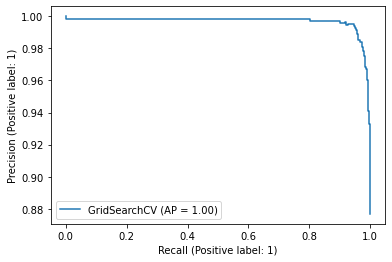

In [528]:
PrecisionRecallDisplay.from_estimator(gs1, X_test, y_test);

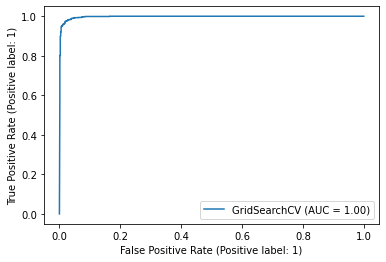

In [529]:
RocCurveDisplay.from_estimator(gs1, X_test, y_test);

In [530]:
y_proba = nb_model1.predict_proba(X_test_cv1)
y_proba

array([[9.99999984e-01, 1.63511898e-08],
       [8.74994907e-01, 1.25005093e-01],
       [9.74889977e-10, 9.99999999e-01],
       ...,
       [1.00000000e+00, 4.59645489e-18],
       [1.00000000e+00, 1.24959582e-19],
       [5.53474373e-02, 9.44652563e-01]])

In [531]:
cv_model1.get_feature_names_out()

array(['00', '00 02', '00 05', ..., '𝗽𝘂𝗽 𝗸𝗶𝘁𝘁𝘆', '𝘆𝗼𝘂', '𝘆𝗼𝘂 𝗴𝗲𝘁'],
      dtype=object)

# Model 2

### CountVectorizer with LogisticRegression

In [532]:
pipe2 = make_pipeline(cvect, LogisticRegression(max_iter=10_000, random_state=333))
pipe2.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, random_state=333))])>

In [533]:
params2 = {
    'countvectorizer__stop_words': ['english'],
    'countvectorizer__ngram_range':[(1,1)], 
    'countvectorizer__max_df':[0.5, 0.7],
    'countvectorizer__min_df':[0],
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': [1.0, .9]
}

In [534]:
gs2 = GridSearchCV(pipe2, params2, n_jobs=-1)
gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=333))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.5, 0.7],
                         'countvectorizer__min_df': [0],
                         'countvectorizer__ngram_range': [(1, 1)],
                         'countvectorizer__stop_words': ['english'],
                         'logisticregression__C': [1.0, 0.9],
                         'logisticregression__penalty': ['l2']})

In [535]:
gs2.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_countvectorizer__max_df', 'param_countvectorizer__min_df', 'param_countvectorizer__ngram_range', 'param_countvectorizer__stop_words', 'param_logisticregression__C', 'param_logisticregression__penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [536]:
results2 = pd.DataFrame(gs2.cv_results_).sort_values(by='mean_test_score', ascending=False)
results2.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_df,param_countvectorizer__min_df,param_countvectorizer__ngram_range,param_countvectorizer__stop_words,param_logisticregression__C,param_logisticregression__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.049799,0.049852,0.193583,0.023779,0.5,0,"(1, 1)",english,1.0,l2,"{'countvectorizer__max_df': 0.5, 'countvectorizer__min_df': 0, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}",0.974082,0.966523,0.963243,0.965405,0.970811,0.968013,0.003910,1
1,1.083159,0.019350,0.183896,0.024664,0.5,0,"(1, 1)",english,0.9,l2,"{'countvectorizer__max_df': 0.5, 'countvectorizer__min_df': 0, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'logisticregression__C': 0.9, 'logisticregression__penalty': 'l2'}",0.974082,0.966523,0.963243,0.965405,0.970811,0.968013,0.003910,1
2,1.126203,0.035561,0.179763,0.013588,0.7,0,"(1, 1)",english,1.0,l2,"{'countvectorizer__max_df': 0.7, 'countvectorizer__min_df': 0, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}",0.974082,0.965443,0.963243,0.964324,0.970811,0.967581,0.004164,3
3,0.798450,0.153642,0.115836,0.028316,0.7,0,"(1, 1)",english,0.9,l2,"{'countvectorizer__max_df': 0.7, 'countvectorizer__min_df': 0, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'logisticregression__C': 0.9, 'logisticregression__penalty': 'l2'}",0.974082,0.965443,0.962162,0.965405,0.970811,0.967581,0.004275,3


In [537]:
gs2.best_params_

{'countvectorizer__max_df': 0.5,
 'countvectorizer__min_df': 0,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': 'english',
 'logisticregression__C': 1.0,
 'logisticregression__penalty': 'l2'}

In [538]:
print('testing score: ', gs2.score(X_test, y_test))
print('training score: ', gs2.score(X_train, y_train))

testing score:  0.9637070641607258
training score:  0.9997838772422736


This second model performed fairly well, but it's not as good as my naive bayes model.